In [2]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  # ImageNet stats
])

# Convert RGBA (4-channel) to RGB (3-channel)
image = Image.open("protein_localization.PNG").convert("RGB")
tensor_image = transform(image).unsqueeze(0)  # Add batch dimension


In [3]:
import torch
import torchvision.models as models

# Load pretrained ResNet-50 and remove classification head
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # removes the final FC layer
resnet.eval()  # Set model to evaluation mode

# Extract features (embedding) from the image
with torch.no_grad():
    embedding = resnet(tensor_image).squeeze().numpy()  # shape: (2048,)

C:\Users\chard\anaconda3\envs\rdkit-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chard\anaconda3\envs\rdkit-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def smiles_to_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array(fp)

In [5]:
!pip install scikit-learn


In [6]:
pip install pubchempy

Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install chembl_webresource_client


In [8]:
from chembl_webresource_client.new_client import new_client

# Search for approved drugs
molecule = new_client.molecule
approved_drugs = molecule.filter(max_phase=4).only(['molecule_chembl_id', 'molecule_structures'])

# Extract SMILES
smiles_list = []
for entry in approved_drugs:
    struct = entry.get('molecule_structures')
    if struct and struct.get('canonical_smiles'):
        smiles_list.append(struct['canonical_smiles'])
    if len(smiles_list) >= 1000:  # limit to 1000
        break

print(f"Fetched {len(smiles_list)} SMILES.")


Fetched 1000 SMILES.


In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def smiles_to_fp(smiles, radius=2, nBits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        return np.array(fp)
    except:
        return None

# Convert all ChEMBL SMILES
mol_fps = []
valid_smiles = []

for smi in smiles_list:
    fp = smiles_to_fp(smi)
    if fp is not None:
        mol_fps.append(fp)
        valid_smiles.append(smi)

mol_fps = np.array(mol_fps)
print(f"Successfully processed {len(valid_smiles)} molecules.")


[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerator
[02:39:04] DEPRECATION WARNING: please use MorganGenerat

Successfully processed 1000 molecules.


[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerator
[02:39:06] DEPRECATION WARNING: please use MorganGenerat

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Reshape for batch comparison
similarities = cosine_similarity([embedding], mol_fps)[0]

# Get top N matches
top_n = 10
top_indices = similarities.argsort()[::-1][:top_n]
top_matches = [valid_smiles[i] for i in top_indices]
top_scores = [similarities[i] for i in top_indices]


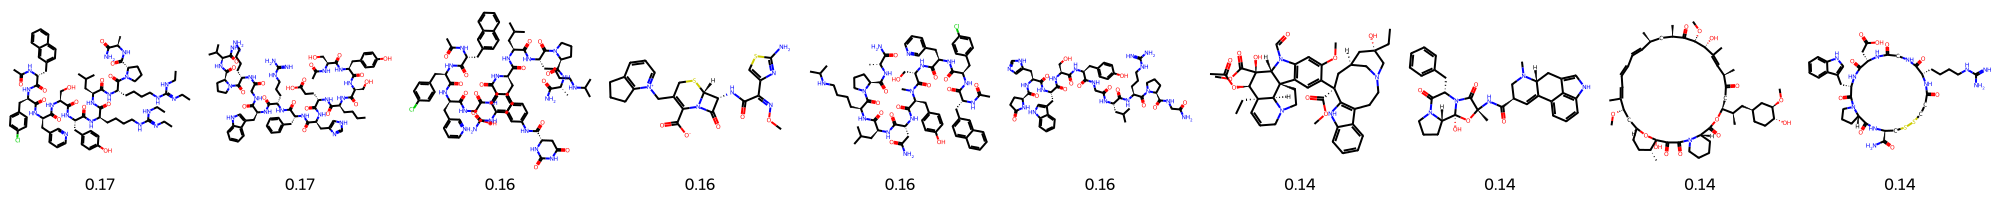

In [11]:
from rdkit.Chem import Draw

top_mols = [Chem.MolFromSmiles(smi) for smi in top_matches]
Draw.MolsToImage(top_mols, legends=[f"{score:.2f}" for score in top_scores])


In [12]:
from rdkit.Chem import Descriptors, QED

def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)

    passed = sum([
        mw <= 500,
        logp <= 5,
        hbd <= 5,
        hba <= 10
    ])
    return passed >= 3

# Filter top matches
filtered_mols = []
filtered_smiles = []
qed_scores = []

for smi in top_matches:
    mol = Chem.MolFromSmiles(smi)
    if mol and passes_lipinski(mol):
        qed_score = QED.qed(mol)
        if qed_score > 0.6:
            filtered_mols.append(mol)
            filtered_smiles.append(smi)
            qed_scores.append(qed_score)


In [13]:
from rdkit import Chem

# Filter only valid RDKit Mol objects
valid_filtered_mols = []
valid_qed_scores = []

for mol, qed in zip(filtered_mols, qed_scores):
    if mol is not None and mol.GetNumAtoms() > 0:
        valid_filtered_mols.append(mol)
        valid_qed_scores.append(qed)


In [14]:
lipinski_pass_count = 0
for smi in valid_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol and passes_lipinski(mol):
        lipinski_pass_count += 1

print(f"Molecules passing Lipinski: {lipinski_pass_count}/{len(valid_smiles)}")


Molecules passing Lipinski: 939/1000


In [15]:
lipinski_hits = []
lipinski_smiles = []

for smi in valid_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol and mol.GetNumAtoms() > 0 and passes_lipinski(mol):
        lipinski_hits.append(mol)
        lipinski_smiles.append(smi)

print(f"Hits passing Lipinski only: {len(lipinski_hits)}")


Hits passing Lipinski only: 939


In [ ]:
from rdkit.Chem import Draw
from PIL import Image

# Assuming lipinski_hits is a list of RDKit molecule objects
# Create image using RDKit's MolsToGridImage
img = Draw.MolsToGridImage(
    lipinski_hits[:25],
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"{i+1}" for i in range(len(lipinski_hits[:25]))]
)

# Directly save the image as a PIL Image
if isinstance(img, Image.Image):
    img.save("lipinski_hits_grid.png")
    print("Saved image as lipinski_hits_grid.png")
else:
    print("The generated object is not a PIL image.")


In [ ]:
from rdkit.Chem import Draw
from PIL import Image
import numpy as np

# Assuming lipinski_hits is a list of RDKit molecule objects
# Create image using RDKit's MolsToGridImage
img = Draw.MolsToGridImage(
    lipinski_hits[:25],
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"{i+1}" for i in range(len(lipinski_hits[:25]))]
)

# Check if the result is a numpy array and convert to PIL Image
if isinstance(img, np.ndarray):
    img = Image.fromarray(img)  # Convert numpy array to PIL image
    img.save("lipinski_hits_grid.png")
    print("Saved image as lipinski_hits_grid.png")
else:
    print("The generated object is not a numpy array or PIL image. Check the data type.")


In [ ]:
from rdkit.Chem import Draw
from PIL import Image

# Assuming lipinski_hits is a list of RDKit molecule objects
# Create image using RDKit's MolsToGridImage
img = Draw.MolsToGridImage(
    lipinski_hits[:25],
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"{i+1}" for i in range(len(lipinski_hits[:25]))]
)

# Print the type of the returned object to understand what's being generated
print(f"Generated object type: {type(img)}")

# Check if it's a numpy array or PIL Image and handle accordingly
if isinstance(img, Image.Image):
    img.save("lipinski_hits_grid.png")
    print("Saved image as lipinski_hits_grid.png")
elif isinstance(img, np.ndarray):
    img = Image.fromarray(img)  # Convert numpy array to PIL image
    img.save("lipinski_hits_grid.png")
    print("Saved image as lipinski_hits_grid.png")
else:
    print("The generated object is not a numpy array or PIL image.")


In [ ]:
from rdkit.Chem import Draw
from PIL import Image
from IPython.core.display import Image as IPImage
from io import BytesIO

# Assuming lipinski_hits is a list of RDKit molecule objects
# Create image using RDKit's MolsToGridImage
img = Draw.MolsToGridImage(
    lipinski_hits[:25],
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"{i+1}" for i in range(len(lipinski_hits[:25]))]
)

# Convert IPython Image to BytesIO
if isinstance(img, IPImage):
    # Convert the IPython Image to a byte stream
    img_data = img.data
    img_bytes = BytesIO(img_data)
    
    # Open this byte stream as a PIL Image
    pil_img = Image.open(img_bytes)
    
    # Save the image as a PNG file
    pil_img.save("lipinski_hits_grid.png")
    print("Saved image as lipinski_hits_grid.png")
else:
    print("The generated object is not an IPython Image.")


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, SDWriter

# Create a new list for valid 3D molecules
valid_3d_mols = []

for mol in lipinski_hits[:25]:
    if mol is None:
        continue

    mol = Chem.AddHs(mol)  # Add hydrogens (important for 3D embedding)
    
    # Try 3D embedding
    status = AllChem.EmbedMolecule(mol, randomSeed=42)
    if status != 0:
        print("Embedding failed for a molecule, skipping...")
        continue

    # Energy minimization (UFF)
    try:
        AllChem.UFFOptimizeMolecule(mol)
        valid_3d_mols.append(mol)
    except:
        print("Minimization failed for a molecule, skipping...")

# Write to SDF
if valid_3d_mols:
    with SDWriter("lipinski_hits_3D_all.sdf") as writer:
        for mol in valid_3d_mols:
            writer.write(mol)
    print(f"Saved {len(valid_3d_mols)} 3D molecules to lipinski_hits_3D_all.sdf")
else:
    print("No valid molecules were embedded.")


In [ ]:
conda install -c conda-forge openbabel


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

suppl = Chem.SDMolSupplier("lipinski_hits_3D_all.sdf")
writer = Chem.SDWriter("lipinski_hits_MMFF_optimized.sdf")

for mol in suppl:
    if mol is None:
        continue
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    writer.write(mol)

writer.close()


In [ ]:
!obabel lipinski_hits_MMFF_optimized.sdf -O ligands.pdbqt -m


In [2]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\The Scripps Research Institute\Autodock\4.2.6"






In [10]:
!autodock4 --help


usage: AutoDock 	-p parameter_filename
			-l log_filename
			-k (Keep original residue numbers)
			-i (Ignore header-checking)
			-t (Parse the PDBQT file to check torsions, then stop.)
			-d (Increment debug level)
			-C (Print copyright notice)
			--version (Print autodock version)
			--help (Display this message)




In [6]:
import os
import shutil
import subprocess

# Paths
ligand_folder = "ligands"  # Folder containing all your ligand .pdbqt files
template_dpf = "template.dpf"  # Your prepared template DPF
output_folder = "batch_docking_results"

# AutoDock executable
autodock_exe = "autodock4.exe"  # Adjust if necessary (e.g., full path)

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Read the template DPF once
with open(template_dpf, 'r') as file:
    template_dpf_content = file.read()

# Loop over all ligands
for ligand_file in os.listdir(ligand_folder):
    if ligand_file.endswith(".pdbqt"):
        ligand_name = os.path.splitext(ligand_file)[0]
        
        # Create a custom .dpf for each ligand
        dpf_content = template_dpf_content.replace("{ligand_name}", ligand_name)
        dpf_filename = os.path.join(output_folder, f"{ligand_name}.dpf")
        
        with open(dpf_filename, 'w') as dpf_file:
            dpf_file.write(dpf_content)
        
        # Copy ligand into output folder
        shutil.copy(os.path.join(ligand_folder, ligand_file), output_folder)

        # Run AutoDock
        print(f"Docking {ligand_name}...")
        subprocess.run([autodock_exe, "-p", dpf_filename, "-l", os.path.join(output_folder, f"{ligand_name}.dlg")])

print("Batch docking complete!")


Docking ligands1...
Docking ligands10...
Docking ligands11...
Docking ligands12...
Docking ligands13...
Docking ligands14...
Docking ligands15...
Docking ligands16...
Docking ligands17...
Docking ligands18...
Docking ligands19...
Docking ligands2...
Docking ligands20...
Docking ligands21...
Docking ligands22...
Docking ligands23...
Docking ligands24...
Docking ligands25...
Docking ligands3...
Docking ligands4...
Docking ligands5...
Docking ligands6...
Docking ligands7...
Docking ligands8...
Docking ligands9...
Batch docking complete!


In [11]:
import os
import re

# Folder containing all your .dlg files
docking_folder = r"C:\Users\chard\batch_docking_results"  # <-- change this!

# Store ligand name and best binding energy
results = []

# Loop through all dlg files
for file in os.listdir(docking_folder):
    if file.endswith(".dlg"):
        filepath = os.path.join(docking_folder, file)
        with open(filepath, 'r') as f:
            content = f.read()
            # Find all binding energy values
            energies = re.findall(r"DOCKED:\s+[-\d\.]+\s+[-\d\.]+\s+[-\d\.]+\s+([-]?\d+\.\d+)", content)
            energies = list(map(float, energies))
            if energies:
                best_energy = min(energies)  # most negative = best
                ligand_name = os.path.splitext(file)[0]
                results.append((ligand_name, best_energy))

# Sort the results by binding energy (most negative first)
results.sort(key=lambda x: x[1])

# Print the ranked results
print("Ligand\tBinding Energy (kcal/mol)")
for ligand, energy in results:
    print(f"{ligand}\t{energy:.2f}")

# Optionally save to CSV
output_file = os.path.join(docking_folder, "docking_results.csv")
with open(output_file, 'w') as f:
    f.write("Ligand,Binding Energy (kcal/mol)\n")
    for ligand, energy in results:
        f.write(f"{ligand},{energy:.2f}\n")

print(f"\nResults saved to {output_file}")


Ligand	Binding Energy (kcal/mol)

Results saved to C:\Users\chard\batch_docking_results\docking_results.csv


C:\Users\chard\AppData\Local\Temp\ipykernel_25828\3222908716.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ligand', y='BindingEnergy (kcal/mol)', data=df, palette='viridis')


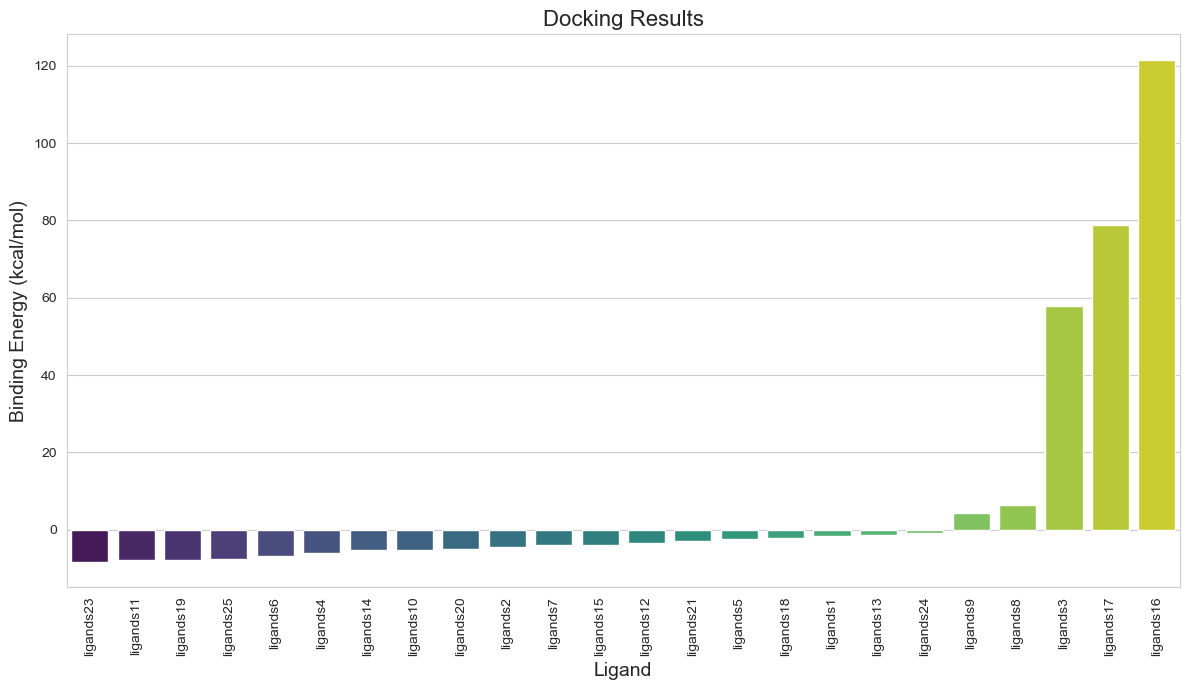

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the docking results
data = {
    'Ligand': ['ligands23', 'ligands11', 'ligands19', 'ligands25', 'ligands6', 'ligands4', 'ligands14', 'ligands10', 
               'ligands20', 'ligands2', 'ligands7', 'ligands15', 'ligands12', 'ligands21', 'ligands5', 'ligands18', 
               'ligands1', 'ligands13', 'ligands24', 'ligands9', 'ligands8', 'ligands3', 'ligands17', 'ligands16'],
    'BindingEnergy (kcal/mol)': [-8.36, -7.87, -7.84, -7.56, -6.73, -6.13, -5.37, -5.28, -5.12, -4.43, -4.08, -3.98, 
                                 -3.38, -3.06, -2.29, -2.07, -1.69, -1.32, -0.88, 4.37, 6.34, 57.77, 78.85, 121.61]
}

# Create DataFrame
df = pd.DataFrame(data)

# Sort DataFrame by BindingEnergy (kcal/mol)
df = df.sort_values('BindingEnergy (kcal/mol)', ascending=True)

# Fancy style
sns.set_style('whitegrid')

# Plot
plt.figure(figsize=(12, 7))

# Use seaborn to create a bar plot
sns.barplot(x='Ligand', y='BindingEnergy (kcal/mol)', data=df, palette='viridis')

# Add title and labels
plt.title('Docking Results', fontsize=16)
plt.xlabel('Ligand', fontsize=14)
plt.ylabel('Binding Energy (kcal/mol)', fontsize=14)

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()
